----- Model Evaluation -----
Logistic Regression: Accuracy = 0.9939 (Time: 0.15s)
Naive Bayes: Accuracy = 0.8619 (Time: 0.00s)
Decision Tree: Accuracy = 1.0000 (Time: 0.04s)
Random Forest: Accuracy = 1.0000 (Time: 1.08s)
K-Nearest Neighbors: Accuracy = 0.9378 (Time: 0.15s)
Gradient Boosting: Accuracy = 1.0000 (Time: 4.93s)
XGBoost: Accuracy = 0.9970 (Time: 0.90s)
LightGBM: Accuracy = 0.9970 (Time: 4.30s)
CatBoost: Accuracy = 0.9985 (Time: 25.95s)
Extra Trees: Accuracy = 0.9909 (Time: 0.32s)


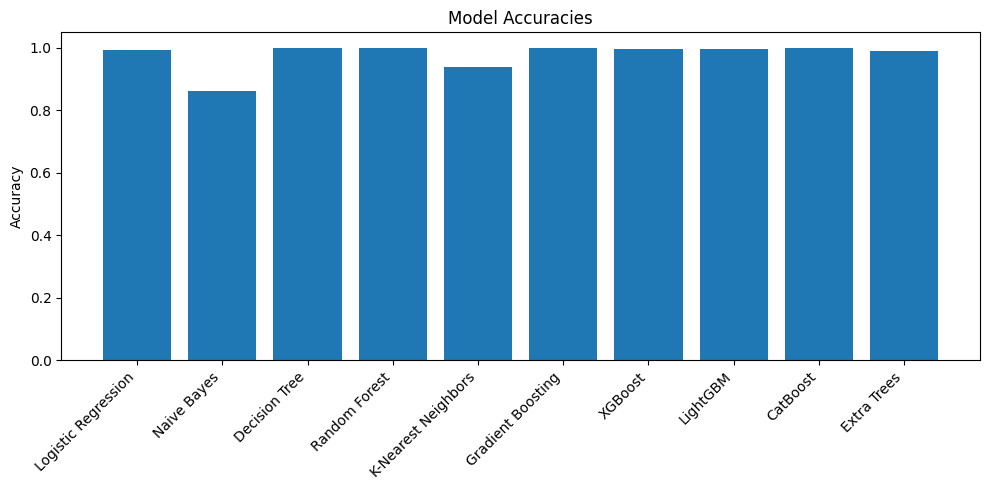

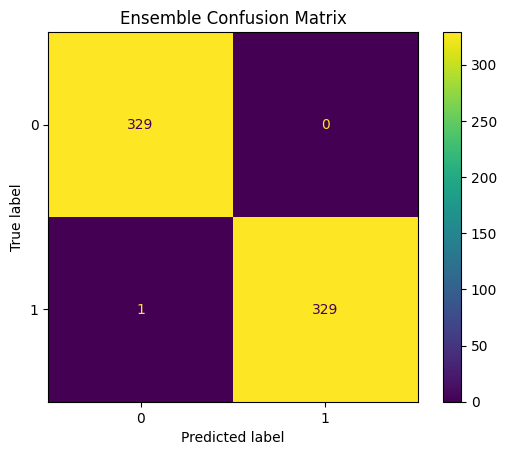

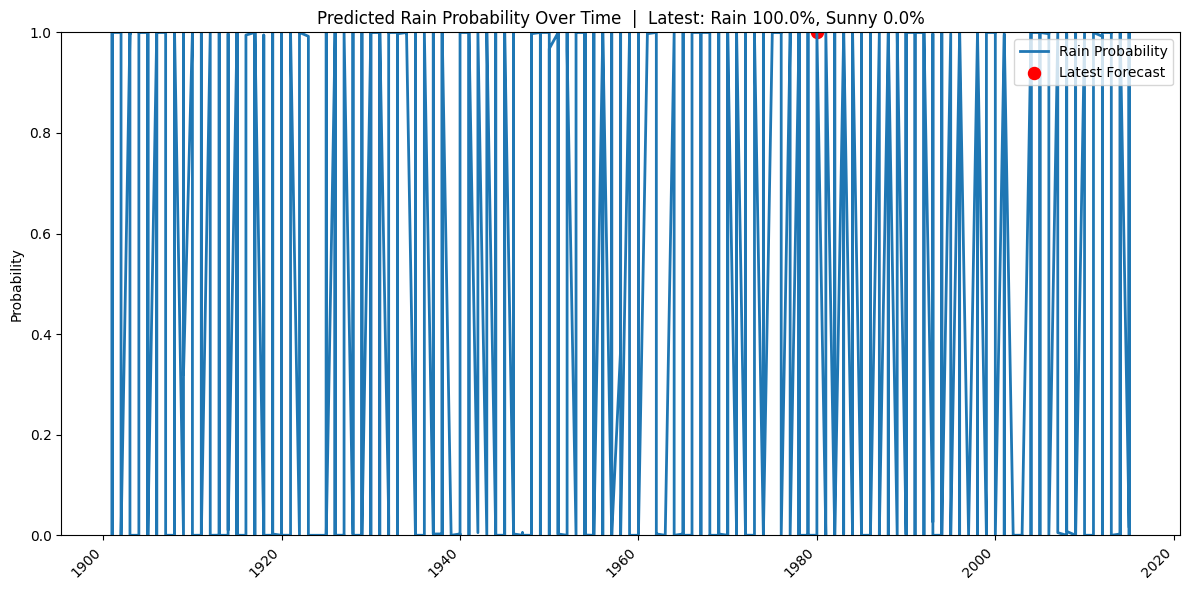

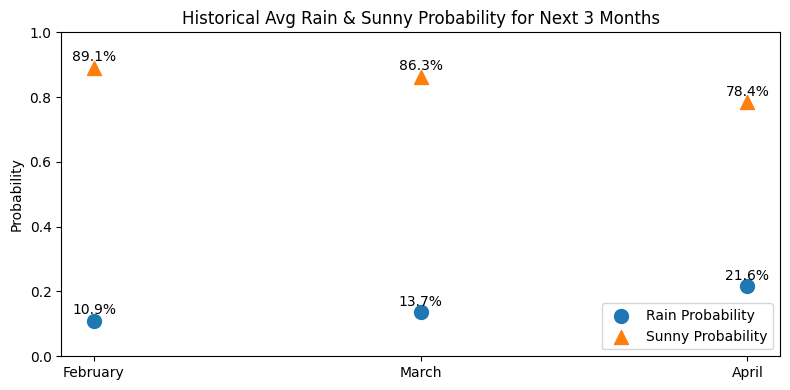


Voting Ensemble Accuracy: 0.9985

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       329
           1       1.00      1.00      1.00       330

    accuracy                           1.00       659
   macro avg       1.00      1.00      1.00       659
weighted avg       1.00      1.00      1.00       659


----- FINAL WEATHER PREDICTION REPORT -----
Prediction Date         : 2025-06-20
Row from Dataset        : 1980-01-01
Predicted Weather       : Rain
Rain Probability        : 99.98%
Sun (No Rain) Probability : 0.02%
-------------------------------------------


In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import pandas as pd
import numpy as np
import time
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import calendar

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# ML Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    VotingClassifier,
)
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Load new dataset
raw_df = pd.read_csv("/content/rainfall in india 1901-2015.csv")

# Remove unneeded columns
if 'SUBDIVISION' in raw_df.columns:
    raw_df.drop(columns=['SUBDIVISION'], inplace=True)

# Convert 'YEAR' to datetime
raw_df['YEAR'] = pd.to_datetime(raw_df['YEAR'], format='%Y')

# Create RainTomorrow column based on average rainfall
monthly_cols = [col for col in raw_df.columns if col not in ['YEAR']]
raw_df['AvgRain'] = raw_df[monthly_cols].mean(axis=1)
threshold = raw_df['AvgRain'].median()
raw_df['RainTomorrow'] = (raw_df['AvgRain'] > threshold).astype(int)

# Fill missing values with median
raw_df.fillna(raw_df.median(numeric_only=True), inplace=True)

# Sample and split data
df = raw_df.sample(frac=0.8, random_state=42).copy()
dates = df['YEAR']
X = df.drop(columns=['YEAR', 'RainTomorrow'])
y = df['RainTomorrow']

X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, dates, stratify=y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_jobs=-1),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(eval_metric="logloss", n_jobs=-1),
    "LightGBM": LGBMClassifier(n_jobs=-1, force_row_wise=True, verbose=-1),
    "CatBoost": CatBoostClassifier(verbose=0, thread_count=-1),
    "Extra Trees": ExtraTreesClassifier(n_jobs=-1),
}

# Evaluate all models
accuracies = {}
print("----- Model Evaluation -----")
for name, model in models.items():
    t0 = time.time()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracies[name] = acc
    print(f"{name}: Accuracy = {acc:.4f} (Time: {time.time() - t0:.2f}s)")

# Plot model accuracies
plt.figure(figsize=(10, 5))
plt.bar(accuracies.keys(), accuracies.values())
plt.xticks(rotation=45, ha='right')
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

# Voting ensemble
ensemble = VotingClassifier(
    estimators=[
        ("rf", models["Random Forest"]),
        ("xgb", models["XGBoost"]),
        ("lgb", models["LightGBM"]),
        ("cat", models["CatBoost"]),
    ],
    voting="soft",
    n_jobs=-1,
)
ensemble.fit(X_train, y_train)
ens_preds = ensemble.predict(X_test)
prob_preds = ensemble.predict_proba(X_test)[:, 1]

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, ens_preds)
plt.title('Ensemble Confusion Matrix')
plt.show()

# Forecast for most recent year
latest = df.iloc[[-1]].copy()
latest_date = latest['YEAR'].values[0]
latest_features = scaler.transform(latest.drop(columns=['YEAR', 'RainTomorrow']))
pred_today = ensemble.predict(latest_features)[0]
prob_today = ensemble.predict_proba(latest_features)[0][1]
sun_prob = 1 - prob_today

# Plot rain probabilities over time
res_df = pd.DataFrame({'Date': dates_test, 'RainProb': prob_preds}).sort_values('Date')
plt.figure(figsize=(12, 6))
plt.plot(res_df['Date'], res_df['RainProb'], label='Rain Probability', linewidth=2)
plt.scatter([latest_date], [prob_today], color='red', s=75, label="Latest Forecast")
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.title(
    f"Predicted Rain Probability Over Time  |  Latest: Rain {prob_today:.1%}, Sunny {sun_prob:.1%}"
)
plt.ylabel('Probability')
plt.legend()
plt.tight_layout()
plt.show()

# Forecast average rain for next 3 months (based on historical averages)
latest_month = pd.to_datetime(latest_date).month
next_months = [(latest_month + i - 1) % 12 + 1 for i in range(1, 4)]
month_names = [calendar.month_name[m] for m in next_months]

# Match months to columns
month_map = {
    'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6,
    'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12
}
inv_month_map = {v: k for k, v in month_map.items()}
monthly_cols = [inv_month_map[m] for m in next_months]

avg_rain = [raw_df[col].mean() / 200 for col in monthly_cols]  # scaled to match binary logic
avg_sun = [1 - r for r in avg_rain]

plt.figure(figsize=(8, 4))
plt.scatter(month_names, avg_rain, s=100, label='Rain Probability', marker='o')
plt.scatter(month_names, avg_sun, s=100, label='Sunny Probability', marker='^')
for i, (r, s) in enumerate(zip(avg_rain, avg_sun)):
    plt.text(i, r + 0.02, f"{r:.1%}", ha='center')
    plt.text(i, s + 0.02, f"{s:.1%}", ha='center')
plt.ylim(0, 1)
plt.title('Historical Avg Rain & Sunny Probability for Next 3 Months')
plt.ylabel('Probability')
plt.legend()
plt.tight_layout()
plt.show()

# Final output summary
print(f"\nVoting Ensemble Accuracy: {accuracy_score(y_test, ens_preds):.4f}")
print("\nClassification Report:\n", classification_report(y_test, ens_preds))

print("\n----- FINAL WEATHER PREDICTION REPORT -----")
print(f"Prediction Date         : {date.today()}")
print(f"Row from Dataset        : {pd.to_datetime(latest_date).date()}")
print(f"Predicted Weather       : {'Rain' if pred_today == 1 else 'Sunny'}")
print(f"Rain Probability        : {prob_today:.2%}")
print(f"Sun (No Rain) Probability : {sun_prob:.2%}")
print("-------------------------------------------")

In [4]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.5 MB/s eta 0:00:00
